In [1]:
# Rex Sutton
#
# Demonstration implementation of Deep Deterministic Policy Gradients, ...
#
# @article{lillicrap2015continuous,
#  title={Continuous control with deep reinforcement learning},
#  author={Lillicrap, Timothy P and Hunt, Jonathan J and Pritzel, Alexander and Heess, Nicolas and Erez, Tom and Tassa, Yuval and Silver, David and Wierstra, Daan},
#  journal={arXiv preprint arXiv:1509.02971},
#  year={2015}
#

import collections
import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

/home/rex/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
env = gym.make('Pendulum-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
# typical starting point for environment
env.reset()

array([ 0.57319809, -0.81941683,  0.54768334])

In [4]:
# action space
print(env.action_space)
print(env.action_space.low)
print(env.action_space.high)

Box(1,)
[-2.]
[2.]


In [5]:
# control space
print(env.observation_space)
print(env.observation_space.low)
print(env.observation_space.high)

Box(3,)
[-1. -1. -8.]
[1. 1. 8.]


In [6]:
# define a replay memory
replay_memory_size = 10000
replay_memory = collections.deque([], maxlen=replay_memory_size)
def sample_memories(batch_size):
    indices = np.random.permutation(len(replay_memory))[:batch_size]
    cols = [[], [], [], [], []] # state, control, reward, nextstate, continue
    for idx in indices:
        memory = replay_memory[idx]
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [7]:
# the actor, given a state returns the controls
def make_actor_network(states, num_ctrls, scope_name):
    initializer = tf.contrib.layers.variance_scaling_initializer()
    kernel_regularizer = tf.contrib.layers.l2_regularizer(0.01)
    with tf.variable_scope(scope_name) as scope:
        # two layers of relu
        hidden_1 = tf.layers.dense(states, units=8,
                                   activation=tf.nn.elu,
                                   kernel_initializer=initializer,
                                   kernel_regularizer=kernel_regularizer)  
        hidden_2 = tf.layers.dense(hidden_1, units=8,
                                   activation=tf.nn.elu,
                                   kernel_initializer=initializer,
                                   kernel_regularizer=kernel_regularizer)  
        actions = tf.layers.dense(hidden_2, num_ctrls,
                                   use_bias=False,
                                   activation=tf.nn.tanh,
                                   kernel_initializer=initializer)  
        # collect the trainable variables
        trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                           scope=scope.name)
        trainable_vars_by_name = {var.name[len(scope.name):]: var
                                  for var in trainable_vars}
    return actions, trainable_vars_by_name

In [8]:
# critic is estimating the expected rewards of the action in the states
def make_critic_network(states, controls, scope_name):
    initializer = tf.contrib.layers.variance_scaling_initializer()
    kernel_regularizer = tf.contrib.layers.l2_regularizer(0.01)
    with tf.variable_scope(scope_name) as scope:
        # pass states through relu
        hidden_1 = tf.layers.dense(states, units=8,
                                   activation=tf.nn.elu,
                                   kernel_initializer=initializer,
                                   kernel_regularizer=kernel_regularizer)
        # another relu layer
        hidden_2 = tf.layers.dense(controls, units=8,
                                   activation=tf.nn.elu,
                                   kernel_initializer=initializer,
                                   kernel_regularizer=kernel_regularizer)  
        # concatenate the hidden layer with the actions
        concat = tf.concat(axis=1, values=[hidden_1, hidden_2])
        # another relu layer
        hidden_3 = tf.layers.dense(concat, units=16,
                                   activation=tf.nn.elu,
                                   kernel_initializer=initializer,
                                   kernel_regularizer=kernel_regularizer)  
        # a linear layer
        outputs = tf.layers.dense(hidden_3, 1,
                                  kernel_initializer=initializer,
                                  kernel_regularizer=kernel_regularizer)  
    # collect the trainable variables
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name    

In [9]:
# make a soft copy from the online to the target
def make_copy_op(target, online):
    return target.assign_sub(0.001 * (target - online))

In [10]:
# return state
tf.set_random_seed(seed=42)
np.random.seed(seed=42)
replay_memory.clear()

In [11]:
# reset the graph before defining it
tf.reset_default_graph()
# problem dimensions
state_dim = 3
num_ctrls = 1
# place holders
states = tf.placeholder(tf.float32, (None, state_dim))
target_states = tf.placeholder(tf.float32, (None, state_dim))
y = tf.placeholder(tf.float32, shape=[None, 1])
# make online networks
actor_outputs, actor_vars = make_actor_network(states, num_ctrls, 'actor')
critic_outputs, critic_vars = make_critic_network(states, actor_outputs, 'critic')
# make target networks
target_actor_outputs, target_actor_vars = make_actor_network(target_states, num_ctrls, 'actor_target')
target_critic_outputs, target_critic_vars = make_critic_network(target_states, target_actor_outputs, 'critic_target')
# make soft copy operations
actor_copy_ops = [make_copy_op(target_actor_vars[var_name], actor_vars[var_name])
                    for var_name in target_actor_vars.keys()]
critic_copy_ops = [make_copy_op(target_critic_vars[var_name], critic_vars[var_name])
                    for var_name in target_critic_vars.keys()]
copy_online_to_target = tf.group(*(actor_copy_ops + critic_copy_ops))
# train the critic (slight divergence from paper in treat error more carefully)
critic_error = tf.abs(y - critic_outputs)
clipped_critic_error = tf.clip_by_value(critic_error, 0.0, 1.0)
linear_critic_error = 2.0 * (critic_error - clipped_critic_error)
critic_loss = tf.reduce_mean(tf.square(clipped_critic_error) + linear_critic_error)
critic_optimizer = tf.train.MomentumOptimizer(learning_rate = 0.005, momentum = 0.95, use_nesterov=True)
critic_training_op = critic_optimizer.minimize(critic_loss, var_list=list(critic_vars.values()))
# train the actor (equivalent to Silver's derivation but easier)
neg_mean_q = -1.0 * tf.reduce_mean(critic_outputs)
actor_optimizer = tf.train.MomentumOptimizer(learning_rate = 0.01, momentum = 0.95, use_nesterov=True)
actor_training_op = actor_optimizer.minimize(neg_mean_q, var_list=list(actor_vars.values()))
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [12]:
# parameters 
save_path = './pendulumv0.ckpt'
max_episodes = 250
max_episode_steps = 200
max_explore_episodes = 100
batch_size = 256
min_replays = 3*batch_size
noise_theta = 0.15
noise_sigma = 0.2
discount_rate = 0.99
control_scalar = 2.0 # pendulum

In [13]:
iteration = 0
episode = 0
episode_step = 0
noise = 0.0
reward = np.nan
done = True
episode_total_reward = 0.0
max_reward = -1e8
critic_loss_val = np.nan
mean_q_val = np.nan

with tf.Session() as sess:
    # initialize variables
    init.run()
    # make the networks initially identical
    copy_online_to_target.run()
    # start environment
    state = env.reset()
    # loop
    while episode < max_episodes:
        # evaluate the controls
        ctrls = actor_outputs.eval(feed_dict={states:[state]})
        ctrls = ctrls.reshape(-1)
        if episode < max_explore_episodes:
             # update exploration noise 
            noise -= ((noise_theta * noise) - noise_sigma * np.random.randn())
            # add in the exploration noise
            p = episode / max_explore_episodes
            ctrls = ctrls * p + (1.0 - p) * noise
        ctrls *= control_scalar
        # step
        next_state, reward, done, _ = env.step(ctrls)
        replay_memory.append((state, ctrls, reward, next_state, 1.0 - done))
        state = next_state
        episode_step +=1
        # track progress
        episode_total_reward += reward
        if reward > max_reward:
            max_reward = reward
        # if excedes the cap on steps end prematurely
        if episode_step >= max_episode_steps:
            done = True
        # if episode has finished
        if done:
            print("Ep {}\tStep {}\tTotRwd {:2f}\tLoss {:5f}\tAvgQ {:2f}\tMaxRwd {:2f}".format(
                episode, episode_step, episode_total_reward, critic_loss_val, mean_q_val, max_reward))
            state = env.reset()
            episode += 1
            episode_step = 0
            episode_total_reward = 0.0
        iteration +=1
        # if not enough replay memories
        if iteration < min_replays:
            # skip training
            continue
        # sample memories
        mem_states, mem_controls, mem_rewards, mem_next_states, mem_continues = (sample_memories(batch_size))
        # train the critic
        q = target_critic_outputs.eval(feed_dict={target_states: mem_next_states})
        y_val = mem_rewards + mem_continues * discount_rate * q
        critic_loss_val, _ = sess.run([critic_loss, critic_training_op], feed_dict={states: mem_states,
                                                                                    actor_outputs: mem_controls,
                                                                                    y: y_val})
        # train the actor
        neg_mean_q_val, _ = sess.run([neg_mean_q, actor_training_op], feed_dict={states: mem_states})
        mean_q_val = -1.0 * neg_mean_q_val
        # copy to target
        copy_online_to_target.run()
    # save results
    print('save:', save_path)    
    saver.save(sess, save_path)

Ep 0	Step 200	TotRwd -1504.175138	Loss   nan	AvgQ nan	MaxRwd -4.719712
Ep 1	Step 200	TotRwd -1274.403934	Loss   nan	AvgQ nan	MaxRwd -1.553310
Ep 2	Step 200	TotRwd -1723.612255	Loss   nan	AvgQ nan	MaxRwd -1.553310
Ep 3	Step 200	TotRwd -1275.167530	Loss 1.453947	AvgQ -8.619713	MaxRwd -0.526186
Ep 4	Step 200	TotRwd -1649.650098	Loss 0.177551	AvgQ -8.015076	MaxRwd -0.526186
Ep 5	Step 200	TotRwd -1296.028377	Loss 0.077982	AvgQ -8.686527	MaxRwd -0.526186
Ep 6	Step 200	TotRwd -994.115728	Loss 0.107734	AvgQ -9.061883	MaxRwd -0.037844
Ep 7	Step 200	TotRwd -1066.341837	Loss 0.079162	AvgQ -10.109612	MaxRwd -0.037844
Ep 8	Step 200	TotRwd -1505.866620	Loss 0.038884	AvgQ -11.098179	MaxRwd -0.037844
Ep 9	Step 200	TotRwd -1249.790099	Loss 0.118232	AvgQ -12.211815	MaxRwd -0.037844
Ep 10	Step 200	TotRwd -1420.985118	Loss 0.082418	AvgQ -12.701385	MaxRwd -0.037844
Ep 11	Step 200	TotRwd -1213.287248	Loss 0.092588	AvgQ -14.150100	MaxRwd -0.037844
Ep 12	Step 200	TotRwd -1155.506371	Loss 0.218009	AvgQ -14.294

Ep 102	Step 200	TotRwd -0.939706	Loss 2.513552	AvgQ -34.708942	MaxRwd -0.000039
Ep 103	Step 200	TotRwd -133.953930	Loss 1.832234	AvgQ -32.764549	MaxRwd -0.000039
Ep 104	Step 200	TotRwd -128.260421	Loss 2.727528	AvgQ -29.961422	MaxRwd -0.000039
Ep 105	Step 200	TotRwd -247.602069	Loss 2.678119	AvgQ -30.393570	MaxRwd -0.000039
Ep 106	Step 200	TotRwd -116.241418	Loss 2.087951	AvgQ -30.975519	MaxRwd -0.000039
Ep 107	Step 200	TotRwd -236.042055	Loss 1.958689	AvgQ -29.464041	MaxRwd -0.000039
Ep 108	Step 200	TotRwd -0.981178	Loss 2.452287	AvgQ -30.730721	MaxRwd -0.000039
Ep 109	Step 200	TotRwd -121.432196	Loss 2.732224	AvgQ -21.781689	MaxRwd -0.000039
Ep 110	Step 200	TotRwd -635.587977	Loss 1.649213	AvgQ -24.470379	MaxRwd -0.000039
Ep 111	Step 200	TotRwd -114.038825	Loss 2.206943	AvgQ -24.146431	MaxRwd -0.000039
Ep 112	Step 200	TotRwd -118.821673	Loss 2.080655	AvgQ -25.528912	MaxRwd -0.000018
Ep 113	Step 200	TotRwd -263.706617	Loss 3.002273	AvgQ -20.112251	MaxRwd -0.000008
Ep 114	Step 200	TotR

Ep 203	Step 200	TotRwd -230.229019	Loss 1.247256	AvgQ -11.246923	MaxRwd -0.000002
Ep 204	Step 200	TotRwd -339.805037	Loss 0.939824	AvgQ -11.264080	MaxRwd -0.000002
Ep 205	Step 200	TotRwd -1.892176	Loss 1.369802	AvgQ -7.071176	MaxRwd -0.000002
Ep 206	Step 200	TotRwd -122.968777	Loss 1.232214	AvgQ -12.738550	MaxRwd -0.000002
Ep 207	Step 200	TotRwd -1506.478559	Loss 1.561733	AvgQ -19.961103	MaxRwd -0.000002
Ep 208	Step 200	TotRwd -118.592165	Loss 3.335334	AvgQ -14.774118	MaxRwd -0.000002
Ep 209	Step 200	TotRwd -1.455667	Loss 1.120627	AvgQ -11.924212	MaxRwd -0.000002
Ep 210	Step 200	TotRwd -258.761004	Loss 1.358643	AvgQ -14.446280	MaxRwd -0.000002
Ep 211	Step 200	TotRwd -505.345098	Loss 2.092023	AvgQ -17.241802	MaxRwd -0.000002
Ep 212	Step 200	TotRwd -116.507288	Loss 1.529723	AvgQ -17.202702	MaxRwd -0.000002
Ep 213	Step 200	TotRwd -299.440746	Loss 1.699035	AvgQ -14.279900	MaxRwd -0.000002
Ep 214	Step 200	TotRwd -223.679415	Loss 1.416615	AvgQ -12.764493	MaxRwd -0.000002
Ep 215	Step 200	TotR

In [16]:
steps = []
cumulative_rewards = []
# run simulations with the saved model
with tf.Session() as sess:
    saver.restore(sess, save_path)
    # for each simulation
    for episode in range(1024):
        done = False
        cumulative_reward = 0.0
        step = 0
        state = env.reset()
        # loop
        print('Ep ', episode)
        while not done:
            ctrls = actor_outputs.eval(feed_dict={states:[state]})
            ctrls = ctrls.reshape(-1)
            ctrls *= control_scalar
            state, reward, done, _ = env.step(ctrls)
            cumulative_reward += reward
            step += 1
        steps.append(step)
        cumulative_rewards.append(cumulative_reward)

INFO:tensorflow:Restoring parameters from ./pendulumv0.ckpt
Ep  0
Ep  1
Ep  2
Ep  3
Ep  4
Ep  5
Ep  6
Ep  7
Ep  8
Ep  9
Ep  10
Ep  11
Ep  12
Ep  13
Ep  14
Ep  15
Ep  16
Ep  17
Ep  18
Ep  19
Ep  20
Ep  21
Ep  22
Ep  23
Ep  24
Ep  25
Ep  26
Ep  27
Ep  28
Ep  29
Ep  30
Ep  31
Ep  32
Ep  33
Ep  34
Ep  35
Ep  36
Ep  37
Ep  38
Ep  39
Ep  40
Ep  41
Ep  42
Ep  43
Ep  44
Ep  45
Ep  46
Ep  47
Ep  48
Ep  49
Ep  50
Ep  51
Ep  52
Ep  53
Ep  54
Ep  55
Ep  56
Ep  57
Ep  58
Ep  59
Ep  60
Ep  61
Ep  62
Ep  63
Ep  64
Ep  65
Ep  66
Ep  67
Ep  68
Ep  69
Ep  70
Ep  71
Ep  72
Ep  73
Ep  74
Ep  75
Ep  76
Ep  77
Ep  78
Ep  79
Ep  80
Ep  81
Ep  82
Ep  83
Ep  84
Ep  85
Ep  86
Ep  87
Ep  88
Ep  89
Ep  90
Ep  91
Ep  92
Ep  93
Ep  94
Ep  95
Ep  96
Ep  97
Ep  98
Ep  99
Ep  100
Ep  101
Ep  102
Ep  103
Ep  104
Ep  105
Ep  106
Ep  107
Ep  108
Ep  109
Ep  110
Ep  111
Ep  112
Ep  113
Ep  114
Ep  115
Ep  116
Ep  117
Ep  118
Ep  119
Ep  120
Ep  121
Ep  122
Ep  123
Ep  124
Ep  125
Ep  126
Ep  127
Ep  128
Ep  129
Ep  130
Ep

(array([  2.,   0.,   0.,   2.,   1.,   4.,  15., 102., 202., 696.]),
 array([-1532.8197729 , -1379.96844815, -1227.1171234 , -1074.26579866,
         -921.41447391,  -768.56314916,  -615.71182442,  -462.86049967,
         -310.00917492,  -157.15785018,    -4.30652543]),
 <a list of 10 Patch objects>)

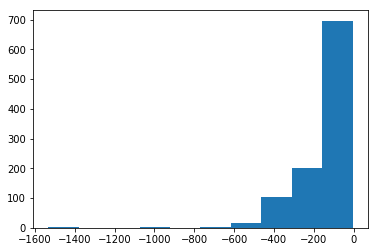

In [17]:
# plot histogram
plt.hist(np.array(cumulative_rewards))

(array([   0.,    0.,    0.,    0.,    0., 1024.,    0.,    0.,    0.,
           0.]),
 array([199.5, 199.6, 199.7, 199.8, 199.9, 200. , 200.1, 200.2, 200.3,
        200.4, 200.5]),
 <a list of 10 Patch objects>)

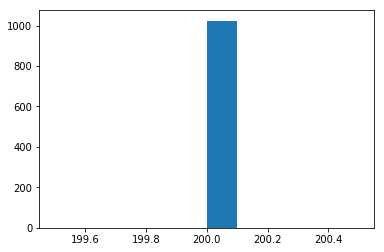

In [18]:
# plot histogram
plt.hist(np.array(steps))